This project will take in a dataset and then predict the loss of the other 

### Imports and CUDA

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Loss Ratio is predicted as 

Loss Ratio=bytes_sent/bytes_retrans​

### Merging all the reno files

In [3]:
# folder_path = "reno"

# # Get a list of all CSV files in the folder
# csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# # Read and merge all CSV files
# df_list = [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files]

# # Concatenate all DataFrames
# merged_df = pd.concat(df_list, ignore_index=True)

# # Save the merged DataFrame to a new CSV file
# merged_df.to_csv(os.path.join(folder_path, "merged_reno.csv"), index=False)

# print("Merging complete. File saved as 'merged_output.csv'.")
# print("merged_reno.csv size: ", merged_df.shape)

# #And then move the file into the root directory

### Preparing the data for RenoCUBIC

I need to normalize the data first, and the continue from there.

In [16]:
import pandas as pd
import numpy as np
import torch

# Load dataset
file_path = "../src/data/switch_tcp.csv"
df = pd.read_csv(file_path, delimiter=";")

# Convert TCP type to numeric
df['tcp_type'] = df['tcp_type'].map({'reno': 1, 'cubic': 0})


# Identify constant columns
constant_columns = [col for col in df.columns if len(df[col].unique()) == 1]
constant_columns += ["bytes_retrans", "bytes_sent"]  # Optional if you plan to drop them



# Drop them
df = df.drop(columns=constant_columns)


# 🔹 Separate target before normalization
target_col = "loss_ratio"

features = df.drop(columns=[target_col])


targets = df[[target_col]]  # Keep as DataFrame to match shape

# 🔹 Normalize features and target separately
features_min = features.min()
features_max = features.max()
features_norm = (features - features_min) / (features_max - features_min)

target_min = float(df['loss_ratio'].min())
target_max = float(df['loss_ratio'].max())
targets_norm = (targets - target_min) / (target_max - target_min)

print(targets.shape)
print(features.shape)
print(features_norm.columns)

(106, 1)
(106, 16)
Index(['wscale', 'rto', 'rtt', 'mss', 'rcvmss', 'advmss', 'cwnd', 'ssthresh',
       'bytes_acked', 'segs_out', 'segs_in', 'data_segs_out', 'lastrcv',
       'rcv_ssthresh', 'tcp_type', 'timestamp'],
      dtype='object')


In [5]:
#As stated in the paper
seq_length = 15
forecast_steps = 15  # Predict the next 15 seconds


def create_sequences(input, labels, seq_length, forecast_steps):
    xs, ys = [], []
    for i in range(len(input) - seq_length - forecast_steps + 1):
        xs.append(input[i : i + seq_length])  # Input sequence
        ys.append(labels[i + seq_length : i + seq_length + forecast_steps])  # Next `forecast_steps` values
    return np.array(xs), np.array(ys)


X, y = create_sequences(features_norm.values, targets_norm['loss_ratio'].values, seq_length, forecast_steps)
data_tensor = torch.tensor(df.values, dtype=torch.float32)
new_X = torch.tensor(X,dtype=torch.float32)
new_y = torch.tensor(y[:,:, None], dtype=torch.float32)
print("Data tensor:", new_X.shape)
print("Loss tensor:", new_y.shape)

Data tensor: torch.Size([77, 15, 16])
Loss tensor: torch.Size([77, 15, 1])


### Splitting the data, 80/10/10

In [6]:
train_size = int(len(new_X) *0.8)
#I remove the first batch because it is just full of zeros,
X_train, X_test = new_X[:train_size], new_X[train_size:]
y_train, y_test = new_y[:train_size], new_y[train_size:]

# Print the shapes to verify the split
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 16  # You can adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Example of accessing a batch of data
for inputs, targets in train_loader:
    print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')
    
    break  # Only print the first batch for verification


torch.Size([61, 15, 16]) torch.Size([16, 15, 16])
torch.Size([61, 15, 1]) torch.Size([16, 15, 1])
Inputs: torch.Size([16, 15, 16]), Targets: torch.Size([16, 15, 1])


###LSTM Model used as the NN.

In [7]:
class LSTM_pt(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_pt, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        # LSTM cell
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers = self.num_layers, batch_first = True)
        
        # Linear layer for final prediction
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, inputs, cell_state=None, hidden_state=None):
        # Forward pass through the LSTM cell
        if hidden_state is None or cell_state is None:
            hidden_state = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size).to(device)
            cell_state = torch.zeros(self.num_layers, inputs.size(0), self.hidden_size).to(device)
        hidden = (cell_state, hidden_state)
        output, new_memory = self.lstm(inputs, hidden)
        cell_state, hidden_state = new_memory
        output = self.linear(output)  # Linear layer on all time steps
        return output, cell_state, hidden_state, # Return correct order

### I will implement sliding window next time, but for now, it will only predict the next value.

In [8]:
def train(model, dataloader, num_epochs, learning_rate):
    # Set the loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()  # Set the model to training mode
    loss_values = []

    for epoch in range(num_epochs):
        total_loss = 0  # Track total loss for averaging
        hidden_state, cell_state = None, None  # Reset hidden states for each epoch

        for batch_idx, (inputs, targets) in enumerate(dataloader):
            if batch_idx == len(dataloader) - 1:  
                break  # Skip the last batch

            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)

            # Compute loss
            loss = criterion(output, targets)
            total_loss += loss.item()  # Sum up the loss for averaging

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Detach hidden states to prevent memory buildup
            hidden_state = hidden_state.detach()
            cell_state = cell_state.detach()

            # # Print some sample outputs periodically
            # if epoch % 50 == 0 and batch_idx % 50 == 0:
            #     print("Output Sample: ", output[1:5])

        # Print average loss for the epoch
        avg_loss = total_loss / len(dataloader)
        loss_values.append(avg_loss)
        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}')
    
    plt.plot(range(num_epochs), loss_values, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.show()


Epoch 1/200, Loss: 0.032994
Epoch 101/200, Loss: 0.000175


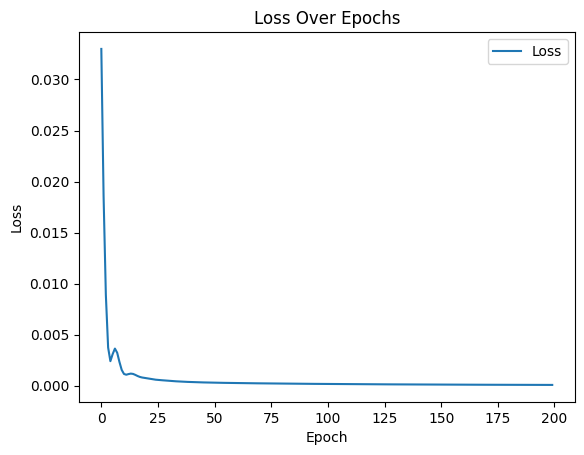

In [9]:
# Define the model parameters
# Following the research paper's instructions
input_size = 16
hidden_size = 20
num_layers = 1 # Can be changed to stack multiple LSTM layers!
output_size = 1
dataloader = train_loader

#Create the model
model = LSTM_pt(input_size, hidden_size, num_layers, output_size).to(device)
train(model, dataloader, num_epochs = 200, learning_rate = 0.001)


### Testing the model

In [10]:
for batch_idx, (inputs, targets) in enumerate(test_loader):
    print(f"Batch {batch_idx}: Inputs Shape: {inputs.shape}, Targets Shape: {targets.shape}")

print("Total test batches:", len(test_loader))


Batch 0: Inputs Shape: torch.Size([16, 15, 16]), Targets Shape: torch.Size([16, 15, 1])
Total test batches: 1


Predicted output (denorm): tensor([[ 1.2444e-06],
        [ 3.6554e-07],
        [ 2.0187e-07],
        [ 1.9352e-07],
        [ 1.0157e-07],
        [ 1.4004e-07],
        [ 3.5602e-07],
        [-1.7915e-07],
        [-2.1700e-07],
        [ 5.5949e-08],
        [ 1.7097e-07],
        [ 2.1869e-07],
        [ 3.6943e-07],
        [ 3.8421e-07],
        [ 3.5126e-07]])
True output (denorm):     tensor([[1.0228e-07],
        [2.7254e-07],
        [2.4558e-07],
        [2.2103e-07],
        [2.1493e-07],
        [1.9675e-07],
        [2.4946e-07],
        [2.1974e-07],
        [2.1568e-07],
        [1.9951e-07],
        [3.6405e-07],
        [3.4559e-07],
        [3.4205e-07],
        [3.2377e-07],
        [3.1877e-07]])
Average Validation Loss: 0.0010580702


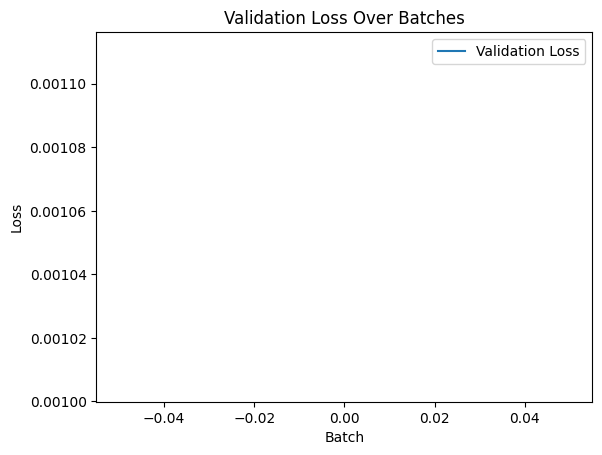

In [11]:
model.eval()

# Initialize variables to track loss
total_val_loss = 0
num_batches = 0
total_lost_values = []

# Define the loss function
criterion = torch.nn.MSELoss()

# Hidden state and cell state
hidden_state, cell_state = None, None  

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        if hidden_state is not None:
            hidden_state = hidden_state.detach()
        if cell_state is not None:
            cell_state = cell_state.detach()

        # Forward pass
        output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)

        # Denormalize using new min/max for target
        output_denorm = output * (target_max - target_min) + target_min
        target_denorm = targets * (target_max - target_min) + target_min

        if batch_idx % 5 == 0:
            print("Predicted output (denorm):", output_denorm[0])
            print("True output (denorm):    ", target_denorm[0])

        # Compute loss using normalized values
        loss = criterion(output, targets)

        # Accumulate and average loss
        total_val_loss += loss.item()
        total_lost_values.append(total_val_loss / (batch_idx + 1))
        num_batches += 1

# Average loss across all batches
avg_loss = total_val_loss / num_batches
print(f'Average Validation Loss: {avg_loss:.10f}')

# Plot the validation loss over batches
import matplotlib.pyplot as plt
plt.plot(range(num_batches), total_lost_values, label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Batches')
plt.legend()
plt.show()


In [12]:
print("output size", output.shape)
print("targets size", targets.shape)

output size torch.Size([16, 15, 1])
targets size torch.Size([16, 15, 1])


In [13]:
# Example raw input: [seq_len, num_features] (unnormalized)
# Use one test sequence (unnormalized)
raw_input = X_test[0]  # shape: [15, 12] – already a tensor if you did earlier prep

# Convert to numpy if it's a tensor
raw_input_np = raw_input.numpy()

# Normalize input using feature-wise min and max (excluding loss_ratio)
normalized_input = (raw_input_np - features_min.values) / (features_max.values - features_min.values)
normalized_input = torch.tensor(normalized_input, dtype=torch.float32).unsqueeze(0)  # [1, seq_len, num_features]

# Prepare target loss_ratio min and max (use float)
target_min = float(df['loss_ratio'].min())
target_max = float(df['loss_ratio'].max())

with torch.no_grad():
    hidden_state, cell_state = None, None
    output, _, _ = model(normalized_input, cell_state, hidden_state)

    # Denormalize the output
    output_denorm = output * (target_max - target_min) + target_min

    print("Normalized model output:", output)
    print("Denormalized prediction:", output_denorm)

avg_prediction = output_denorm.mean().item()

print(f"Average Denormalized Prediction: {avg_prediction:.10f}")



Normalized model output: tensor([[[-0.0668],
         [-0.0823],
         [-0.0847],
         [-0.0850],
         [-0.0850],
         [-0.0850],
         [-0.0850],
         [-0.0850],
         [-0.0850],
         [-0.0850],
         [-0.0850],
         [-0.0850],
         [-0.0850],
         [-0.0850],
         [-0.0850]]])
Denormalized prediction: tensor([[[-1.4544e-06],
         [-1.7929e-06],
         [-1.8438e-06],
         [-1.8508e-06],
         [-1.8518e-06],
         [-1.8519e-06],
         [-1.8519e-06],
         [-1.8515e-06],
         [-1.8519e-06],
         [-1.8519e-06],
         [-1.8519e-06],
         [-1.8519e-06],
         [-1.8519e-06],
         [-1.8519e-06],
         [-1.8519e-06]]])
Average Denormalized Prediction: -0.0000018208


In [14]:
def run_RenoCubic(input_30):
    with torch.no_grad():
        hidden_state, cell_state = None, None
        output, _, _ = model(normalized_input, cell_state, hidden_state)

        # Denormalize the output
        output_denorm = output * (target_max - target_min) + target_min

        print("Normalized model output:", output)
        print("Denormalized prediction:", output_denorm)
        avg_prediction = output_denorm.mean().item()
        print(f"Average Denormalized Prediction: {avg_prediction:.10f}")


    return avg_prediction

def run_Reno(input_30):
    with torch.no_grad():
            hidden_state, cell_state = None, None

            #Change model to renoModel
            output, _, _ = model(normalized_input, cell_state, hidden_state)

            # Denormalize the output
            output_denorm = output * (target_max - target_min) + target_min

            print("Normalized model output:", output)
            print("Denormalized prediction:", output_denorm)
            avg_prediction = output_denorm.mean().item()
            print(f"Average Denormalized Prediction: {avg_prediction:.10f}")


    return avg_prediction


def run_Cubic(input_30):
    with torch.no_grad():
            hidden_state, cell_state = None, None
            #Change model to cubicModel
            output, _, _ = model(normalized_input, cell_state, hidden_state)

            # Denormalize the output
            output_denorm = output * (target_max - target_min) + target_min

            print("Normalized model output:", output)
            print("Denormalized prediction:", output_denorm)
            avg_prediction = output_denorm.mean().item()
            print(f"Average Denormalized Prediction: {avg_prediction:.10f}")


    return avg_prediction


def choose_model(model_input, input_30):
    #Reno is 1, cubic is 0
    if model_input == 1:
        avg_RenoCubic_result = run_RenoCubic(input_30)
        avg_Reno_result = run_Reno(input_30)

        if avg_RenoCubic_result > avg_Reno_result:
            return 1
        else:
            return 0

    #CC is cubic
    if model_input == 0:
        avg_RenoCubic_result = run_RenoCubic(input_30)
        avg_Cubic_result = run_Cubic(input_30)

        if avg_RenoCubic_result > avg_Reno_result:
            return 0
        else:
            return 1




In [17]:
torch.save(model.state_dict(), "RenoCubic_weights.pth")